# Delay Tolerant Networks

### Description

In several instances, network communications can occur with relevant delays, as for extra-terrestial communications or for supervised monitoring networks. In such network deciding which node can communicate with which other node and when is extremely complicated issue (a np-completed scheduling problem).

### Assignments

1. Generate a series of patterns of trasmissions on a network represented as a graph. In such graph the edges are weighted accordingly to the delay between transmittion and reception.
2. Implement euristic algorithms to lower the potential of the network, i.e. aiming at minimizing the distance of the communications from their final destination.
3. Find out the most efficient algorithm

### Contacts
Leonardo Badia <badia@dei.unipd.it>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import math

n = 10
c = 3e8
T_tx = 10  # da regolare
r_max = 60e9  # Marte
tau_max = 130

In [2]:
### Generates a random network of n nodes (the first one corresponds to earth)
### r = max distance

def generate_network(n,r_max,seed=100,polar = False):
    
    np.random.seed(seed)
    
    r = np.random.rand(n,1)*r_max
    r[0] = 0 #Earth
    theta = np.random.rand(n,1)*4*np.pi - 2*np.pi
    phi = np.random.rand(n,1)*4*np.pi - 2*np.pi
    
    if polar==True:
        return np.hstack((r,theta,phi))  #polar coordinates
    
    x = r * np.cos(theta) * np.sin(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(phi)
    
    return np.hstack((x,y,z))   #cartesian coordinates

In [3]:
### Creates the weighted adjacency matrix of the network
### Entries represent propagation times between nodes

def adjacency_matrix(nodes,tau_max):
    
    n1 = nodes[:, np.newaxis, :]
    n2 = nodes[np.newaxis, :, :]
    
    A = np.linalg.norm(n1-n2, axis = 2)/c
    A[A>tau_max] = np.inf
    
    return A

In [4]:
nodes = generate_network(n,r_max)
A = adjacency_matrix(nodes,tau_max)
sorted_nodes = np.argsort(A[0,:])     #sorting based on distance from Earth

if(False):   #TEST
    print(nodes.shape)
    print(A.shape)
    print("sorted_nodes: {}".format(sorted_nodes))

In [5]:
def plot_network(nodes):
    
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(nodes[1:,0],nodes[1:,1],nodes[1:,2])
    ax.scatter(nodes[0,0],nodes[0,1],nodes[0,2],color="red",s=100)   #Earth
    plt.show()

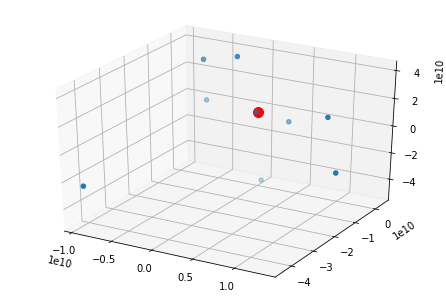

In [6]:
plot_network(nodes)

In [7]:
## disable some links for a certain amount of time
##
## modes:
## light mode: few links, short time
## heavy mode: few links, long time
## unstable mode: many links, short time
## extreme mode: many links, long time
##
## priority: random, near, far
## prioritize disabling of links involving nodes near or far from Earth
## 
## custom_n_targets = number of targets
## custom_offtimes: array containing possible values for off times expressed in number of updates of A

def disable_links(A,n_updates, mode="light",priority="random", custom_n_targets = None, custom_offtimes = None):

    n = A.shape[0]
    
    At = np.repeat(A[:, :, np.newaxis], n_updates, axis=2) #add temporal dimension

    sorted_nodes = np.argsort(A[0,:])
    t_nodes = np.arange(n)
    
    if priority == "random":
        np.random.shuffle(t_nodes)   #nodes targeted for link removal
    elif priority == "near":
        t_nodes = sorted_nodes[:int(np.ceil(n/3))]
    elif priority == "far":
        t_nodes = np.flip(sorted_nodes)[:int(np.ceil(n/3))]
    
    possible_links = []
    possible_links = np.array([[x,y] for x in t_nodes for y in range(n) if x!=y if A[x,y]!=np.inf if [y,x] not in possible_links])

    if mode == "light":  
        n_targets = possible_links.shape[0]//3
        offtimes = [n_updates//10]   # selected links stay off for around 1/10 of the total time
            
    elif mode == "heavy":
        n_targets = possible_links.shape[0]//3
        offtimes = [n_updates//3]
        
    elif mode == "unstable":
        n_targets = possible_links.shape[0]*3//4
        offtimes = [n_updates//10]
        
    elif mode == "extreme":
        n_targets = possible_links.shape[0]*3//4
        offtimes = [n_updates//3]
    
    else:   #use light mode if a wrong 
        print("Wrong value for \"mode\", light mode will be used")
        n_targets = possible_links.shape[0]//3
        offtimes = [n_updates//10]
    
    if custom_n_targets != None: n_targets = custom_n
    if custom_offtimes != None: offtimes = custom_offtimes
 
    disabled_links = np.random.permutation(possible_links)[:n_targets,:]
    
    for link in disabled_links:
        start = np.random.randint(0,n_updates)
        end = start + np.random.choice(offtimes)
        
        if(False):   # TEST
            print(link)
            print("start {}".format(start))
            print("end {}".format(end))
        At[link[0],link[1],start:min(end, n_updates)] = At[link[1],link[0],start:min(end, n_updates)] = np.inf 
            
    return At

In [8]:
### TEST disable links
### sorted nodes = [0 4 5 8 1 2 9 3 6 7]

if(False):   #TEST
    At = disable_links(A,100,mode="light")

    for i in range(20):
        B = np.copy(At[:,:,i*5])
        B[B>tau_max] = 0
        plt.spy(B)
        plt.show()

In [9]:
#used to check if the time exceeds the maximum time of the system
def check_time_step(A, time):
    
    max_time_step = A.shape[2]
    
    if time >= max_time_step:
        raise Exception("Maximum time limit exceded")

# used to check if the link becomes unavailable before the packet is fully transmitted
#weigths = time series of the weight of the considered link
#start = starting time
#end = ending time
def check_interval(weights, start, end):
    return np.sum(weights[int(start):int(end)] == np.inf) == 0 

#finds the next useful interval to send the packet if the link is down
#current_time = earlyest time when the packet can be sent
#delta_time = time interval 
#e2e = end to end delay
#distances = weights of the edge during time
def find_next_interval(current_time, delta_time, e2e, distances):
    
    current_delta = math.floor(current_time / delta_time)
    #the last timeslot has to be considered as well so ceil is needed
    ending_delta = math.ceil((current_time+e2e) / delta_time)
    
    #if we already have a good interval then the packet can be sent immediatly
    if check_interval(distances, current_delta, ending_delta):
        return current_time
    #otherwise iterate until a good interval is found
    else:
        #time of the first np.inf after current_time
        i = current_delta + np.argmin(distances[current_delta:ending_delta] != np.inf)
        
        #number of timesteps required to send a packet
        delta_e2e = np.ceil(e2e / delta_time)
        
        #keep increasing i while either the max length is reached or a good interval is found
        while i + delta_e2e < distances.shape[0] and not check_interval(distances, i, i + delta_e2e):
            i += 1
        
        return i * delta_time

#used to find the next node and the arrival times
def find_next(starting_node, previous, times, earth=0):
    
    result = -1
    current = earth
    
    while current != starting_node:
        result = current
        current = int(previous[current])
    
    return result, times[result]
       
#performs a modified version of the dijkstra algorithm that adapts to this specific problem
#A = adjacency matrix
#starting_node = node sending the packet
#ttr = transmission time
#delta_time = timestep dimension
#earth = earth node
def DTN_dijkstra(A, starting_node, starting_time, ttr, delta_time, earth = 0):
    
    N = A.shape[0]
    
    #setting the arrival time of the packet to each node to infinity
    distances = np.ones(N) * np.inf
    distances[starting_node] = starting_time
    
    current = starting_node
    visited_nodes = 0
    
    #previous step in the shortest path
    previous = np.ones(N)*(-1)
    
    #keep going until the shortest path to earth is found
    while current != earth:
        
        #arrival time of the packet in the current node
        current_time = distances[current]
        #time slot of the packet arrival
        current_step = math.floor(current_time / delta_time)
        
        #checking if the packet arrives after the maximum time
        check_time_step(A, current_step)
        
        #arrival times to each node if the message started from current node
        new_dists = np.zeros(N)
        
        #compute the arrival time to each node
        for i in range(N):
            
            #computing e2e delay as tp + ttr
            tp = np.min(A[current, i, :])
            
            if tp == np.inf:
                new_dists[i] = np.inf
            else:
                e2e = np.min(A[current, i, :]) + ttr
            
                #finding out when the packet can leave the current node to reach the next one
                next_good = find_next_interval(current_time, delta_time, e2e, A[current, i, :])
            
                #finding out the arrival time of the packet to node i after passing from current
                new_dists[i] = next_good + e2e
        
        new_dists[current] = current_time
        
        #if the arrival time is improved then the previous node is changed
        previous[distances > new_dists] = current
        
        #setting the correct arrival time to each node
        distances = np.minimum(distances, new_dists)
        
        visited_nodes += 1
        sorting_indexes = np.argsort(distances)
        
        current = sorting_indexes[visited_nodes]
    
    return find_next(starting_node, previous, distances)

In [10]:
starting_node = 1
starting_time = 0
ttr = 50
delta_time = 50
At = disable_links(A, 2000, mode = "unstable")

In [11]:
next_node, arrival_time = DTN_dijkstra(At, starting_node, starting_time, ttr, delta_time)

print(f"Next Node = {next_node}, arrival time = {arrival_time}")
print(f"tp = {At[starting_node, next_node, 0]}")

Next Node = 0, arrival time = 105.67387701875923
tp = 55.67387701875923


In [12]:
###DELAY FUNCTION###

#This function takes in input 3 parameters: 
# 1) scheduling is defined as a list of lists in the sense that it is a list that contains the scheduling of 
#every node which corresponds to the istants of time a node has to forward packets that are in its queue. For 
#every node these "forwarding istants" are compactly put in a list.
# 2) routing is a slightly more complicated data structure; Here for every node we place a list whose elements 
#are the lists containg the hops that every packet in the queue of a specific node has to go through in order to 
#reach its destination
# 3) n_pkts is the total number of packets that has to be forwarded in our network

def delay(scheduling,routing,n_pkts):

    #The waiting list is obtained as a result of the concatenation of all the lists present in scheduling
    waiting = [wait for node in scheduling for wait in node] 
    #The routes list instead of having all the forwarding times, it contains all the hops every pkt has to do
    routes = [path for node in routing for path in node]
    
    longest = 0
    
    for i in range(n_pkts):
        path = routes[i]
        #Here with tleft we are not taking into account the fact that a packet may be queued in some intermediate 
        #nodes on its remaining way to destination. Anyway this does not represent a problem given the fact that 
        #our scheduling provides us not just with the information about when a packet is sent from its 
        #source node but also all the instants it will be forwarded by intermediate nodes.
        #As we see tleft is made of the sum of transmission and propagation time for every remaining hop
        tleft = sum([T_tx + A[path[j],path[j+1]] for j in range(len(path)-1)]) 
          
            
        #The total time is given by the sum of the time we wait before forwarding and tleft which can be seen as
        #the minimum time it takes to go through the rest of the path
        t_tot = waiting[i] + tleft 
        
        #Here we are looking for the last packet to arrive at destination
        longest = max(longest,t_tot)  
    return longest

In [13]:
#TEST 
#Here we test our function with 3 packets
if(False):
    n_pkts = 3
    T_tx = 0.5
    A=np.zeros((3,3))
    A[0,1] = A[1,0] = 1
    A[1,2] = A[2,1] = 2
    A[0,2] = 3

    scheduling = [[2,4],[1,5.5],[]]
    routing = [[[0,2],[0,1,2]],[[1,2]],[]]

    delay = delay(scheduling,routing,n_pkts)
    print(delay)

<IPython.core.display.Javascript object>


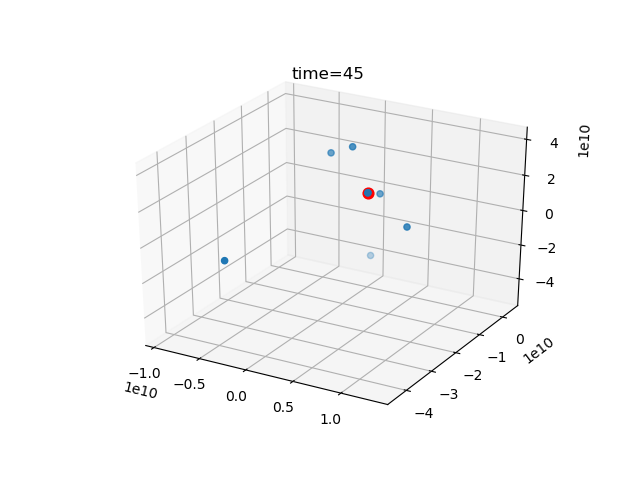

In [14]:
## ANIMATION 1

%matplotlib notebook

coord = np.copy(nodes)
polar = generate_network(n,r_max,polar=True)

def update_graph(num):

    theta = polar[:,1]
    phi = polar[:,2]
    
    old_r = np.linalg.norm(coord,axis=1)
    
    coord[:,0] += - c*np.cos(theta)*np.sin(phi)
    coord[:,1] += - c*np.sin(theta)*np.sin(phi)
    coord[:,2] += - c*np.cos(phi)
    
    new_r = np.linalg.norm(coord,axis=1)
    
    not_done = new_r < old_r  #this happens after a packet reach Earth

    #coord = coord * not_done.reshape((n,-1))  #sets coordinates of a pkt to 0 if it already reached Earth

    for i in range(n):    # ISSUE: previous line doesn't work, this "for" cycle is a substitute
        if not not_done[i]:
            coord[i,0] = coord[i,1] = coord[i,2] = 0
            
    graph._offsets3d = (coord[:,0],coord[:,1],coord[:,2])
    title.set_text("time={}".format(num))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('Pkts')

graph = ax.scatter(coord[:,0],coord[:,1],coord[:,2])
ax.scatter(0,0,0,color="red",s=60)   #Earth

ani = animation.FuncAnimation(fig, update_graph, 
                               interval=50, blit=False)

plt.show()